# Pitch control
The aim of this notebook is to reimplement pitch control and understands different steps.
* [Friends of Tracking github link](https://github.com/Friends-of-Tracking-Data-FoTD/LaurieOnTracking/blob/master/Tutorial3_PitchControl.py)
* [Spearman video](https://www.youtube.com/watch?v=5X1cSehLg6s&t=522s) 
* [Spearman article](/Users/gabin/Ordinateur/Documents/Informatique/ressources/football/off_the_ball_scoring_opportunities.pdf)

## Requirements

**kernel** : liverpool_analytics_kernel from 
**conda environment** : liverpool_analytics_challenge_env

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

In [3]:
from metrica_football_func import Metrica_IO as mio
from metrica_football_func import Metrica_PitchControl as mpc
from metrica_football_func import Metrica_Viz as mviz
from metrica_football_func import Metrica_Velocities as mvel

## Import data

In [4]:
tracking_home,tracking_away,events=mio.read_match_data('data_inputs/metrica_football',2)

Reading team: home
Reading team: away


In [5]:
events = mio.to_metric_coordinates(events)
tracking_home = mio.to_metric_coordinates(tracking_home)
tracking_away = mio.to_metric_coordinates(tracking_away)

In [6]:
tracking_home = mvel.calc_player_velocities(tracking_home,smoothing=True,filter_='moving_average')
tracking_away = mvel.calc_player_velocities(tracking_away,smoothing=True,filter_='moving_average')

## Calculating Pitch Control

### Pitch control definition

> Pitch control (at a given location on the field) is the probability that a team will gain 
possession if the ball is moved to that location on the field. 

### Basic pitch control

The simplest approximation to define the control of a location is to say that the closest player controls this location. This approach is in fact equivalent to using Voronoi tesselation. It is possible to calculate the voronoi zones without calculating the distance of the players to each point of the field. This is more efficient. Nevertheless we don't implement it here because we will then improve the process for which we will be obliged to make the step of calculating the pitch control in each point of the field.

#### Players information
Along pitch control study, for each situation we will need different players information. To be more efficient we create a class like Laurie Shaw made on [his tutorial](https://github.com/Friends-of-Tracking-Data-FoTD/LaurieOnTracking/blob/master/Tutorial3_PitchControl.py).

In [7]:
class player(object):

    # player object holds position, velocity
    def __init__(self,player_id,team,teamname,params={'amax':7,'vmax':5},xgrid):
        self.id = player_id
        self.teamname = teamname
        self.playername = "%s_%s_" % (teamname,player_id)
        self.get_position(team)
        self.get_velocity(team)
        self.vmax = params['vmax']
        self.amax = params['amax']
        self.reaction_time = params['vmax']/params['amax']
        self.pitch_control = 0. # initialise this for later
        
    def get_position(self,team):
        self.position = np.array( [ team[self.playername+'x'], team[self.playername+'y'] ] )
        self.inframe = not np.any( np.isnan(self.position) )
        
    def get_velocity(self,team):
        self.velocity = np.array( [ team[self.playername+'vx'], team[self.playername+'vy'] ] )
        if np.any( np.isnan(self.velocity) ):
            self.velocity = np.array([0.,0.])

In [57]:
def initialise_players(team,teamname,params={'amax':7,'vmax':5},xgrid=50,ygrid=32):
    
    # get player  ids
    player_ids = np.unique( [ c.split('_')[1] for c in team.keys() if c[:4] == teamname ] )
    # create list
    team_players = []
    for p in player_ids:
        # create a player object for player_id 'p'
        team_player = player(p,team,teamname,params=params)
        if team_player.inframe:
            team_players.append(team_player)
            
    return team_players

#### Calculate and plot basic pitch control

In [9]:
def distance_to_location(location,player):
    origin=player.position
    return(np.linalg.norm(location-origin))

def calculate_basic_pitch_control_at_location(location, home_players, away_players, distance_function = distance_to_location):
    
    #initialise distance to location
    distance=np.inf
    closest_player=None
    closest_team=None
    
    for player in home_players:
        #calculate distance from player to location
        d=distance_function(location,player)
        if d<distance:
            closest_player=player.playername
            closest_team=player.teamname
            distance=d
            
    for player in away_players:
        #calculate distance from player to location
        d=distance_function(location,player)
        if d<distance:
            closest_player=player.playername
            closest_team=player.teamname
            distance=d
      
    if closest_team=='Home':
        #if Home team is closest --> probability to possess the ball=1 while for away time proba=0
        return(1,0)
    
    if closest_team=='Away':
        return(0,1)
        

def basic_pitch_control_for_frame(tracking_home,tracking_away,frame, field_dimen = (106.,68.,), n_grid_cells_x = 50, distance_function = distance_to_location):
    
    # break the pitch down into a grid
    n_grid_cells_y = int(n_grid_cells_x*field_dimen[1]/field_dimen[0])
    xgrid = np.linspace( -field_dimen[0]/2., field_dimen[0]/2., n_grid_cells_x)
    ygrid = np.linspace( -field_dimen[1]/2., field_dimen[1]/2., n_grid_cells_y )
    
    #intialise pitch control
    pitch_control_home = np.zeros( shape = (len(ygrid), len(xgrid)) )
    pitch_control_away = np.zeros( shape = (len(ygrid), len(xgrid)) )
    
    # initialise player positions and velocities for pitch control calc (so that we're not repeating this at each grid cell position)
    home_players = initialise_players(tracking_home.loc[frame],'Home')
    away_players = initialise_players(tracking_away.loc[frame],'Away')
    
    # calculate pitch control at each location on the pitch
    for i in range( len(ygrid) ):
        for j in range( len(xgrid) ):
            location = np.array( [xgrid[j], ygrid[i]] )
            
            # we calculate pitch control for home and away team because we will need it for more advance 
            # pitch control model, but it useless with basic pitch control
            pitch_control_home[i,j],pitch_control_away[i,j] = calculate_basic_pitch_control_at_location(location, home_players, away_players, distance_function = distance_function)
            
    return pitch_control_home,xgrid,ygrid

def plot_basic_pitch_control_for_frame(tracking_home,tracking_away,frame, figax=None, field_dimen = (106.,68.,), field_color='white', n_grid_cells_x = 50, alpha = 0.7, include_player_velocities=True, annotate=True, distance_function = distance_to_location):
    
    if figax is None: # create new pitch 
        fig,ax = mviz.plot_pitch(field_dimen=field_dimen, field_color= field_color)
    else: # overlay on a previously generated pitch
        fig,ax = figax # unpack tuple
    
    pitch_control,xgrid,ygrid=basic_pitch_control_for_frame(tracking_home,tracking_away, frame, field_dimen = field_dimen, n_grid_cells_x = n_grid_cells_x, distance_function = distance_function)
    
    #plot frame
    mviz.plot_frame( tracking_home.loc[frame], tracking_away.loc[frame] , figax=(fig,ax), PlayerAlpha=alpha, include_player_velocities=include_player_velocities, annotate=annotate)
    
    # plot pitch control surface
    cmap = 'bwr'
    im=ax.imshow(np.flipud(pitch_control), extent=(np.amin(xgrid), np.amax(xgrid), np.amin(ygrid), np.amax(ygrid)),vmin=0.0,vmax=1.0,cmap=cmap,alpha=0.5)
    fig.colorbar(im)
    
    return fig,ax

(<Figure size 1200x800 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10eaf4b80>)

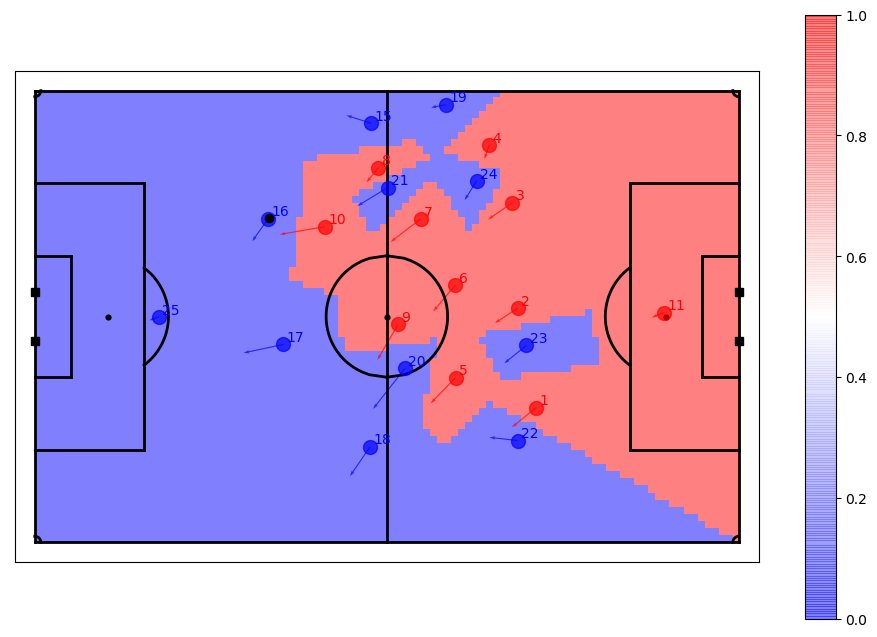

In [10]:
plot_basic_pitch_control_for_frame(tracking_home,tracking_away,2000, n_grid_cells_x=100 )

This approach is very simple and give a first approximation of how players occupy the field. However this is very approximative as it doesn't take into account that players are moving. 

To tackle it, instead of using distance to determine closest player to a location, we can use the time it takes for him to reach the location.

### Dynamic pitch control

As defined precedently, pitch control (at a given location on the field) is the probability that a team will gain 
possession if the ball is moved to that location on the field.

Therefore, in previous approach, we considered that ball can be moved instantaneously to a location and that a team will gain possession (probability=1) if the closest player to this location is a player of this team.

[Spearman and al.](/Users/gabin/Ordinateur/Documents/Informatique/ressources/football/off_the_ball_scoring_opportunities.pdf) model is more precise and complex. For a given location $\vec{r}$, they calculate **time of flight of ball** ($T_f$) at this location. Then probability that a player j, at time t, gain possession at this location between T and T+dT (T>t) is :

\begin{equation}
    dPC_j(t,\vec{r}, T|s, \lambda_j) = \left(1-\sum{PC_k(t,\vec{r}, T|s, \lambda_j)}\right)f_j(t,\vec{r}, T|s)\lambda_jdT
    \label{eq:1} \tag{1}
\end{equation}

if $T<T_f$ else, $dPC_j(t,\vec{r}, T|s, \lambda_j)=0$. 

* $f_j(t,\vec{r}, T|s)$ represents the probability that player j reaches $\vec{r}$ within time T.
* $\lambda_jdT$ represents the probability that player j can control the ball.

By integrating equation \ref{eq:1} over T from 0 to $+\inf$ and summing over players, we obtain team pitch control.

#### Time it takes a player to reach a location (time to intercept in Spearman's paper)
To take into account players movement, we will calculate the time to arrive to a location for each player instead of the distance to the location. In his tutorial, Laurie Shaw suggests that we use a two stages approximation to calculate it : 
 
* First, there is an intinial reaction time roughly determined as vmax/amax.
    
* Then the player runs towards the target location at their maximum speed vmax.

But it is also possible to solve the equations of motion of the player. I detail both approaches in [this notebook](/Users/gabin/Ordinateur/Documents/Informatique/experiments/metrica_football_time_to_reach_a_location.ipynb) that can be consulted if necessary. Particularly, I discuss the value of vmax and amax chosen ($5m/s$ and $7m/s^2$) although I'll respect these ones as Spearman tuned all parameters using these values. For the following we use the function improved_time_to_reach_location which solves the equation of motion to calculate the time it takes a player to reach the location.

Once we've calculated the time to reach a location $\tau$, we have to introduce incertainty. To do so, Spearman and al. transform this time to a probability that player j reaches $\vec{r}$ within time T using a sigmoid function :

\begin{equation}
    f_j(t,\vec{r}, T|s)=\frac{1}{1+\exp(-\pi\frac{T-\tau}{\sqrt{3}s})}
    \label{eq:2} \tag{2}
\end{equation}

Parameter s, which quantifies temporal uncertainty on time it takes a player to reach a location, is estimated to 0.54s.

Let's add a method to player class to calculate the time it takes a player to reach a location and the probability to reach location within time T.

In [54]:
class player(object):

    # player object holds position, velocity
    def __init__(self,player_id,team,teamname,params={'amax':7,'vmax':5,'ttrl_sigma':0.54},xgrid=50,ygrid=32):
        self.id = player_id
        self.teamname = teamname
        self.playername = "%s_%s_" % (teamname,player_id)
        self.get_position(team)
        self.get_velocity(team)
        self.vmax = params['vmax']
        self.amax = params['amax']
        self.reaction_time = params['vmax']/params['amax']
        self.ttrl_sigma=params['ttrl_sigma'] # Standard deviation of sigmoid function in Spearman 2018 ('s') that determines uncertainty in player arrival time
        self.pitch_control = 0. # initialise this for later
        self.pitch_control_surface = np.zeros( shape = (ygrid, xgrid) )
        
    def get_position(self,team):
        self.position = np.array( [ team[self.playername+'x'], team[self.playername+'y'] ] )
        self.inframe = not np.any( np.isnan(self.position) )
        
    def get_velocity(self,team):
        self.velocity = np.array( [ team[self.playername+'vx'], team[self.playername+'vy'] ] )
        if np.any( np.isnan(self.velocity) ):
            self.velocity = np.array([0.,0.])
            
    def simple_time_to_reach_location(self,location):
    
        reaction_time=self.vmax/self.amax
        r_reaction = self.position + self.velocity*reaction_time
        arrival_time = reaction_time + np.linalg.norm(location-r_reaction)/self.vmax
        self.time_to_reach_location=arrival_time
        return(arrival_time)
    
    def improved_time_to_reach_location(self,location):
        Xf=location
        X0=self.position
        V0=self.velocity
        alpha = self.amax/self.vmax
        
        #equations of motion + equation 3 from assumption that the player accelerate 
        #with constant acceleration amax to vmax
        #we have to add abs(t) to make t be positive
        def equations(p):
            vxmax, vymax, t = p
            eq1 = Xf[0] - (X0[0] + vxmax*(abs(t) - (1 - np.exp(-alpha*abs(t)))/alpha)+((1 - np.exp(-alpha*abs(t)))/alpha)*V0[0])
            eq2 = Xf[1] - (X0[1] + vymax*(abs(t) - (1 - np.exp(-alpha*abs(t)))/alpha)+((1 - np.exp(-alpha*abs(t)))/alpha)*V0[1])
            eq3 = np.sqrt(vxmax**2+vymax**2) - self.vmax
            return (eq1,eq2,eq3)
        
        #prediction for three unknowns
        t_predict=np.linalg.norm(Xf-X0)/self.vmax+0.7
        v_predict=self.vmax*(Xf-X0)/np.linalg.norm(Xf-X0)
        vxmax, vymax, t =  fsolve(equations, (v_predict[0], v_predict[1], t_predict))

        self.time_to_reach_location=abs(t)
        
        return(abs(t))
    
    def probability_to_reach_location(self,T):
        f = 1/(1. + np.exp( -np.pi/np.sqrt(3.0)/self.ttrl_sigma * (T-self.time_to_reach_location ) ) )
        return f
    

#### Control the ball
For a given interval $\Delta t$ that the player is in the vicinity of the ball, the quantity $\Delta t\lambda$ gives the probability that this player can control the ball during $\Delta t$. 
Intuitively, attackers have to make a precise control of the ball while defenders only have to kick-it out away. That's why Spearman and al. introduce a parameter $\kappa$ so that :

\begin{equation}
    \lambda_j=\lambda \text{ if player j is an attacker}\\
    \lambda_j=\kappa\lambda \text{ if player j is a defender}\\
    \label{eq:3} \tag{3}
\end{equation}

Moreover, if attacking player j is in offside position, $\lambda_j=0$

Spearman and al. respectively set values of $\lambda$ and $\kappa$ at $3.99s^{-1}$ and $1.72$.

#### Time of Flight
In the paper, Spearman and al. explains that they simulate different trajectories of the ball to reach a given location using aerodynamic drag. Theren't so much detail on it. I will follow what suggest Laurie Shaw in his tutorial : approximate time of flight by the distance from the ball to the location divided by ball's average speed.

#### Calculate and plot dynamic pitch control
Now that we've detailed dynamic pitch control process, we can create a function to calculate it. I'm mainly going to take over the [function developed by Laurie Shaw](https://github.com/Friends-of-Tracking-Data-FoTD/LaurieOnTracking/blob/master/Tutorial3_PitchControl.py) and customize some parts. 

##### Parameters
First we use the function parameters to set all parameters used in the paper

In [12]:
def parameters():
    """
    default_model_params()
    
    Returns the default parameters that define and evaluate the model. See Spearman 2018 for more details.
    
    Parameters
    -----------
    time_to_control_veto: If the probability that another team or player can get to the ball and control it is less than 10^-time_to_control_veto, ignore that player.
    
    
    Returns
    -----------
    
    params: dictionary of parameters required to determine and calculate the model
    
    """
    # key parameters for the model, as described in Spearman 2018
    params = {}
    # model parameters
    params['amax'] = 7. # maximum player acceleration m/s/s
    params['vmax'] = 5. # maximum player speed m/s
    params['ttrl_sigma'] = 0.54 # Standard deviation of sigmoid function in Spearman 2018 ('s') that determines uncertainty in player arrival time
    params['kappa_def'] =  1. # kappa parameter in Spearman 2018 that gives the advantage defending players to control ball
    params['lambda_att'] = 3.99 # ball control parameter for attacking team
    params['lambda_def'] = 3.99 * params['kappa_def'] # ball control parameter for defending team
    params['average_ball_speed'] = 15. # average ball travel speed in m/s
    # numerical parameters for model evaluation
    params['int_dt'] = 0.04 # integration timestep (dt)
    params['max_int_time'] = 10 # upper limit on integral time
    params['model_converge_tol'] = 0.01 # assume convergence when PPCF>0.99 at a given location.
    # The following are 'short-cut' parameters. We do not need to calculated PPCF explicitly when a player has a sufficient head start. 
    # A sufficient head start is when the a player arrives at the target location at least 'time_to_control' seconds before the next player
    params['time_to_control_att'] = 3*np.log(10) * (np.sqrt(3)*params['ttrl_sigma']/np.pi + 1/params['lambda_att'])
    params['time_to_control_def'] = 3*np.log(10) * (np.sqrt(3)*params['ttrl_sigma']/np.pi + 1/params['lambda_def'])
    
    # sigma normal distribution for relevant pitch control
    params['sigma_normal'] = 23.9
    # alpha : dependence of the decision conditional probability by the PPCF
    params['alpha'] = 1.04
    
    return params

##### Find attacking team
To determine the probability to control the ball, we have to know which team attacks and which team defends during the frame on which we want to calculate pitch control. To do so, we use events data assuming that a team attacks if it possesses the ball. A change of possession is described either by the event "RECOVERY" or by the event "SET PIECE". We have to keep in mind that there can be errors during possession transitions.

In [13]:
def attacking_team_frame(events,frame):
    
    #the game doesn't start at frame 0, so we check that the frame asked is superior to the frame when game starts
    assert frame>=events['Start Frame'][0],'frame before game start'
    
    attacking_team=events[((events.Type=="RECOVERY") | (events.Type=="SET PIECE")) & (events['Start Frame']<=frame)]['Team'].values[-1] 

    return(attacking_team)

attacking_team_frame(events,10000)

'Away'

##### Find offside players
As we said, before, players who are in offside position can't control the ball. Let's compute a function to find offside attackers

In [14]:
def where_home_team_attacks(home_team,events):
    '''
    Determines where teams attack on the first period using team x average position at game start
    
    Returns
    -------
        -1 if home team attacks on the left (x<0)
        1 if home team attacks on the right (x>0)
    
    '''
    game_start_frame=events.iloc[0]['Start Frame']
    home_team_x_cols=[c for c in home_team.columns if c.split('_')[-1]=='x' and c.split('_')[-2]!='ball']

    if home_team.loc[game_start_frame,home_team_x_cols].mean()>0:
        return(-1)
    else:
        return(1)
    
def find_offside_players(attacking_players, defending_players, where_attack, ball_pos):
    '''
    Determines which attacking players are in offside position. 
    A player is caught offside if he’s nearer to the opponent’s goal 
    than both the ball and the second-last opponent (including the goalkeeper).
    
    Returns
    -------
        offside_players : the list of offside players names
    '''
    
    offside_players=[]
    
    # if attacking team attacks on the right
    if where_attack==1:
        
        #find the second-last defender
        x_defending_players=[]
        for player in defending_players:
            x_defending_players.append(player.position[0])
        x_defending_players=np.sort(x_defending_players)
        second_last_defender_x=x_defending_players[-2]
        
        for player in attacking_players:
            position=player.position
            #if player is nearer to the opponent's goal than the ball
            if position[0]>ball_pos[0] and position[0]>second_last_defender_x:
                offside_players.append(player)
    
    # if attacking team attacks on the right
    if where_attack==-1:
        
        #find the second-last defender
        x_defending_players=[]
        for player in defending_players:
            x_defending_players.append(player.position[0])
        x_defending_players=np.sort(x_defending_players)
        second_last_defender_x=x_defending_players[1]
        
        for player in attacking_players:
            position=player.position
            #if player is nearer to the opponent's goal than the ball
            if position[0]<ball_pos[0] and position[0]<second_last_defender_x:
                offside_players.append(player.playername)
                
    return(offside_players)

##### Calculate pitch control at a location

In [15]:
def calculate_pitch_control_at_target(target_position, attacking_players, defending_players, ball_start_pos, where_attack, params):
    """ calculate_pitch_control_at_target
    
    Calculates the pitch control probability for the attacking and defending teams at a specified target position on the ball.
    
    Parameters
    -----------
        target_position: size 2 numpy array containing the (x,y) position of the position on the field to evaluate pitch control
        attacking_players: list of 'player' objects (see player class above) for the players on the attacking team (team in possession)
        defending_players: list of 'player' objects (see player class above) for the players on the defending team
        ball_start_pos: Current position of the ball (start position for a pass). If set to NaN, function will assume that the ball is already at the target position.
        where_attack: where attacking team attacks (1 on the right, -1 on the left)
        params: Dictionary of model parameters
        
    Returns
    -----------
        PPCFatt: Pitch control probability for the attacking team
        PPCFdef: Pitch control probability for the defending team ( 1-PPCFatt-PPCFdef <  params['model_converge_tol'] )
    """
    
    # calculate ball travel time from start position to end position.
    if ball_start_pos is None or any(np.isnan(ball_start_pos)): # assume that ball is already at location
        ball_travel_time = 0.0 
    else:
        # ball travel time is distance to target position from current ball position divided assumed average ball speed
        ball_travel_time = np.linalg.norm( target_position - ball_start_pos )/params['average_ball_speed']
        
    # find offside attacking players
    offside_players=find_offside_players(attacking_players, defending_players, where_attack, ball_start_pos)
    
    # first get arrival time of 'nearest' attacking player (nearest also dependent on current velocity) (if player isn't offside)
    tau_min_att = np.nanmin( [p.improved_time_to_reach_location(target_position) for p in attacking_players if p.playername not in offside_players] )
    tau_min_def = np.nanmin( [p.improved_time_to_reach_location(target_position) for p in defending_players] )
    
    # check whether we actually need to solve equation 
    if tau_min_att-max(ball_travel_time,tau_min_def) >= params['time_to_control_def']:
        # if defending team can arrive significantly before attacking team, no need to solve pitch control model
        return 0., 1.
    elif tau_min_def-max(ball_travel_time,tau_min_att) >= params['time_to_control_att']:
        # if attacking team can arrive significantly before defending team, no need to solve pitch control model
        return 1., 0.
    else: 
        # solve pitch control model by integrating equation 3 in Spearman et al.
        # first remove any player that is far (in time) from the target location
        attacking_players = [p for p in attacking_players if p.time_to_reach_location-tau_min_att < params['time_to_control_att'] ]
        defending_players = [p for p in defending_players if p.time_to_reach_location-tau_min_def < params['time_to_control_def'] ]
        
        # set up integration arrays
        dT_array = np.arange(ball_travel_time-params['int_dt'],ball_travel_time+params['max_int_time'],params['int_dt']) 
        PPCFatt = np.zeros_like( dT_array )
        PPCFdef = np.zeros_like( dT_array )
        
        # set PPCF to 0. for each player
        for player in attacking_players:
            player.pitch_control=0.
        for player in defending_players:
            player.pitch_control=0.
        
        # integration equation 3 of Spearman 2018 until convergence or tolerance limit hit (see 'params')
        ptot = 0.0
        i = 1
        
        while 1-ptot>params['model_converge_tol'] and i<dT_array.size: 
            T = dT_array[i]
            for player in attacking_players:
                
                # calculate lambda for 'player' (0 if offside)
                if player.playername in offside_players:
                    lambda_att=0
                else:
                    lambda_att=params['lambda_att']
                    
                # calculate ball control probablity for 'player' in time interval T+dt
                dPPCFdT = (1-PPCFatt[i-1]-PPCFdef[i-1])*player.probability_to_reach_location( T ) * lambda_att
                
                # make sure it's greater than zero
                assert dPPCFdT>=0, 'Invalid attacking player probability (calculate_pitch_control_at_target)'

                player.pitch_control += dPPCFdT*params['int_dt'] # total contribution from individual player
                PPCFatt[i] += player.pitch_control # add to sum over players in the attacking team (remembering array element is zero at the start of each integration iteration)
                
            for player in defending_players:
                # calculate ball control probablity for 'player' in time interval T+dt
                dPPCFdT = (1-PPCFatt[i-1]-PPCFdef[i-1])*player.probability_to_reach_location( T ) * params['lambda_def']
                
                # make sure it's greater than zero
                assert dPPCFdT>=0, 'Invalid defending player probability (calculate_pitch_control_at_target)'

                player.pitch_control += dPPCFdT*params['int_dt'] # total contribution from individual player
                PPCFdef[i] += player.pitch_control # add to sum over players in the defending team
                
            ptot = PPCFdef[i]+PPCFatt[i] # total pitch control probability 
            i += 1
        if i>=dT_array.size:
            print("Integration failed to converge: %1.3f" % (ptot) )
            
        return PPCFatt[i-1], PPCFdef[i-1]

In [16]:
params=parameters()
home_players = initialise_players(tracking_home.loc[1000],'Home',params)
away_players = initialise_players(tracking_away.loc[1000],'Away',params)
attacking_team=attacking_team_frame(events,1000)
where_home_attacks = where_home_team_attacks(tracking_home,events)
period=tracking_home.loc[1000]['Period']
if attacking_team=='Home':
    if period==1:
        where_attack=where_home_attacks
    else:
        where_attack=-where_home_attacks
else:
    if period==1:
        where_attack=-where_home_attacks
    else:
        where_attack=where_home_attacks
calculate_pitch_control_at_target(np.array([0,0]), home_players, away_players, np.array([0,70]), where_attack, params)

(0.6464252143709222, 0.35103353049341957)

##### Generate pitch control for frame

In [55]:
def generate_pitch_control_for_frame(frame, tracking_home, tracking_away, events, params, field_dimen = (106.,68.,), n_grid_cells_x = 50, return_players=False):
    """ generate_pitch_control_for_frame
    
    Evaluates pitch control surface over the entire field at the moment of the given frame
    
    Parameters
    -----------
        frame: instant at which the pitch control surface should be calculated
        tracking_home: tracking DataFrame for the Home team
        tracking_away: tracking DataFrame for the Away team
        events: Dataframe containing the event data
        params: Dictionary of model parameters (default model parameters can be generated using default_model_params() )
        field_dimen: tuple containing the length and width of the pitch in meters. Default is (106,68)
        n_grid_cells_x: Number of pixels in the grid (in the x-direction) that covers the surface. Default is 50.
                        n_grid_cells_y will be calculated based on n_grid_cells_x and the field dimensions
        
    Returrns
    -----------
        PPCFa: Pitch control surface (dimen (n_grid_cells_x,n_grid_cells_y) ) containing pitch control probability for the attcking team.
               Surface for the defending team is just 1-PPCFa.
        xgrid: Positions of the pixels in the x-direction (field length)
        ygrid: Positions of the pixels in the y-direction (field width)
    """
    
    # get the details of the event (team in possession, ball_start_position, where team in possession attacks)
    attacking_team = attacking_team_frame(events,frame)
    assert attacking_team=='Home' or attacking_team=='Away', 'attacking team should be Away or Home'
    
    ball_start_pos = np.array( [ tracking_home.loc[frame]['ball_x'], tracking_home.loc[frame]['ball_y'] ] )
    
    where_home_attacks = where_home_team_attacks(tracking_home,events)
    period=tracking_home.loc[frame]['Period']
    if attacking_team=='Home':
        if period==1:
            where_attack=where_home_attacks
        else:
            where_attack=-where_home_attacks
    else:
        if period==1:
            where_attack=-where_home_attacks
        else:
            where_attack=where_home_attacks
        
    # break the pitch down into a grid
    n_grid_cells_y = int(n_grid_cells_x*field_dimen[1]/field_dimen[0])
    xgrid = np.linspace( -field_dimen[0]/2., field_dimen[0]/2., n_grid_cells_x)
    ygrid = np.linspace( -field_dimen[1]/2., field_dimen[1]/2., n_grid_cells_y )
    
    # initialise pitch control grids for attacking and defending teams 
    PPCFa = np.zeros( shape = (len(ygrid), len(xgrid)) )
    PPCFd = np.zeros( shape = (len(ygrid), len(xgrid)) )
    
    # initialise player positions and velocities for pitch control calc (so that we're not repeating this at each grid cell position)
    if attacking_team=='Home':
        attacking_players = initialise_players(tracking_home.loc[frame],'Home',params, xgrid=len(xgrid), ygrid=len(ygrid))
        defending_players = initialise_players(tracking_away.loc[frame],'Away',params, xgrid=len(xgrid), ygrid=len(ygrid))
    else:
        defending_players = initialise_players(tracking_home.loc[frame],'Home',params, xgrid=len(xgrid), ygrid=len(ygrid))
        attacking_players = initialise_players(tracking_away.loc[frame],'Away',params, xgrid=len(xgrid), ygrid=len(ygrid))

    # calculate pitch control model at each location on the pitch
    # if we want to save individual pitch control
    if return_players:
        for i in range( len(ygrid) ):
            for j in range( len(xgrid) ):
                target_position = np.array( [xgrid[j], ygrid[i]] )
                PPCFa[i,j],PPCFd[i,j] = calculate_pitch_control_at_target(target_position, attacking_players, defending_players, ball_start_pos, where_attack, params)
                for player in attacking_players:
                    player.pitch_control_surface[i,j] = player.pitch_control
                for player in defending_players:
                    player.pitch_control_surface[i,j] = player.pitch_control
    else:
        for i in range( len(ygrid) ):
            for j in range( len(xgrid) ):
                target_position = np.array( [xgrid[j], ygrid[i]] )
                PPCFa[i,j],PPCFd[i,j] = calculate_pitch_control_at_target(target_position, attacking_players, defending_players, ball_start_pos, where_attack, params)

    # check probabilitiy sums within convergence
    checksum = np.sum( PPCFa + PPCFd ) / float(n_grid_cells_y*n_grid_cells_x ) 
    assert abs(1-checksum) < params['model_converge_tol'], "Checksum failed: %1.3f" % (1-checksum)
    
    if return_players:
        players_pitch_control = {}
        for player in attacking_players:
            players_pitch_control[player.playername] = player.pitch_control_surface
        for player in defending_players:
            players_pitch_control[player.playername] = player.pitch_control_surface
            
        return(PPCFa,xgrid,ygrid,players_pitch_control)
    
    return PPCFa,xgrid,ygrid

##### Plot dynamic pitch control

In [18]:
def plot_pitch_control_for_frame(frame, tracking_home, tracking_away, events, params, alpha = 0.7, include_player_velocities=True, annotate=True, field_dimen = (106.,68.,), n_grid_cells_x = 50):
    """ plot_pitch_control_for_frame(frame, tracking_home, tracking_away, events, params ,PPCF, xgrid, ygrid )
    
    Plots the pitch control surface at the instant of the frame. Player and ball positions are overlaid.
    
    Parameters
    -----------
        frame: the instant at which the pitch control surface should be calculated
        events: Dataframe containing the event data
        tracking_home: (entire) tracking DataFrame for the Home team
        tracking_away: (entire) tracking DataFrame for the Away team
        PPCF: Pitch control surface (dimen (n_grid_cells_x,n_grid_cells_y) ) containing pitch control probability for the attcking team (as returned by the generate_pitch_control_for_event in Metrica_PitchControl)
        xgrid: Positions of the pixels in the x-direction (field length) as returned by the generate_pitch_control_for_event in Metrica_PitchControl
        ygrid: Positions of the pixels in the y-direction (field width) as returned by the generate_pitch_control_for_event in Metrica_PitchControl
        alpha: alpha (transparency) of player markers. Default is 0.7
        include_player_velocities: Boolean variable that determines whether player velocities are also plotted (as quivers). Default is False
        annotate: Boolean variable that determines with player jersey numbers are added to the plot (default is False)
        field_dimen: tuple containing the length and width of the pitch in meters. Default is (106,68)
        
    Returns
    -----------
       fig,ax : figure and aixs objects (so that other data can be plotted onto the pitch)
    """    
    # plot frame and event
    fig,ax = mviz.plot_pitch(field_color='white', field_dimen = field_dimen)
    mviz.plot_frame( tracking_home.loc[frame], tracking_away.loc[frame], figax=(fig,ax), PlayerAlpha=alpha, include_player_velocities=include_player_velocities, annotate=annotate )
    
    #generate pitch control
    PPCF, xgrid, ygrid=generate_pitch_control_for_frame(frame, tracking_home, tracking_away, events, params, field_dimen = field_dimen, n_grid_cells_x = n_grid_cells_x)
    
    #find attacking team
    attacking_team = attacking_team_frame(events,frame)
    
    # plot pitch control surface
    if attacking_team=='Home':
        cmap = 'bwr'
    else:
        cmap = 'bwr_r'
    ax.imshow(np.flipud(PPCF), extent=(np.amin(xgrid), np.amax(xgrid), np.amin(ygrid), np.amax(ygrid)),interpolation='hanning',vmin=0.0,vmax=1.0,cmap=cmap,alpha=0.5)
    
    return fig,ax

(<Figure size 1200x800 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11755d340>)

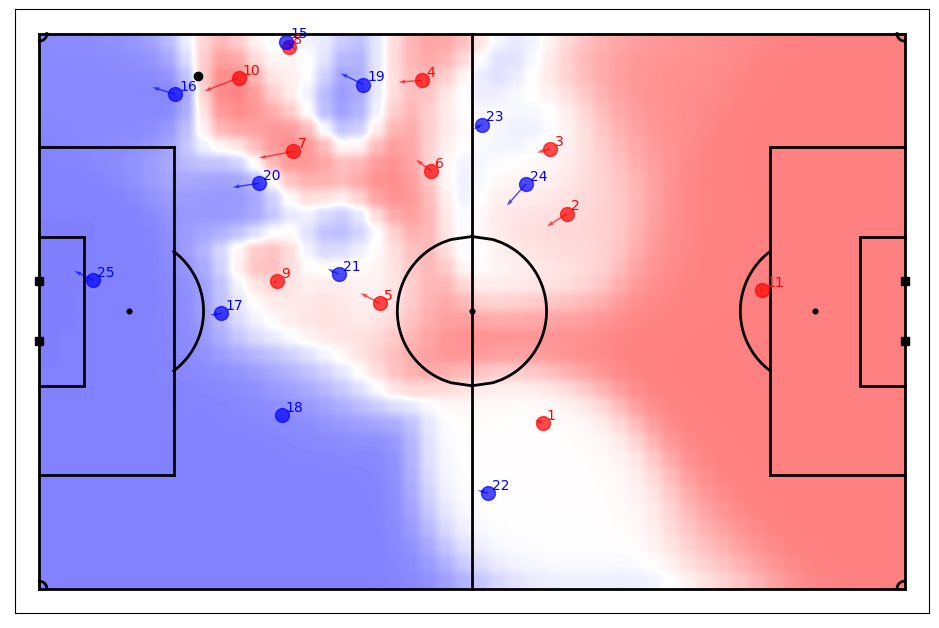

In [63]:
plot_pitch_control_for_frame(1000, tracking_home, tracking_away, events, params)

(<Figure size 1200x800 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x119de46a0>)

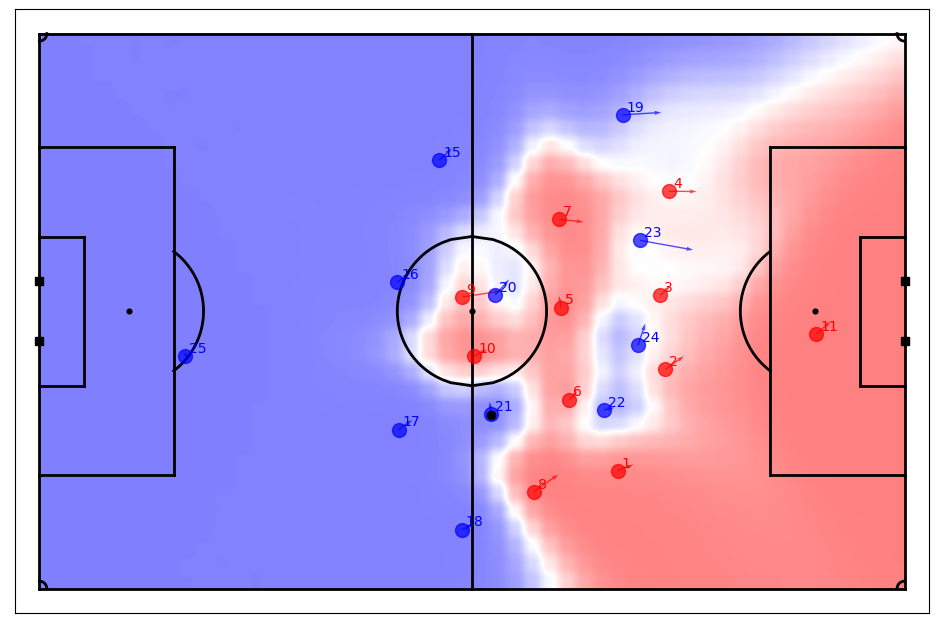

In [36]:
params=parameters()
plot_pitch_control_for_frame(52871, tracking_home, tracking_away, events, params)

##### Plot pitch control for event

In [19]:
def plot_pitch_control_for_event(event_id, events, tracking_home, tracking_away, params, alpha = 0.7, include_player_velocities=True, annotate=True, field_dimen = (106.,68.,), n_grid_cells_x = 50):
    """ generate_pitch_control_for_event
    
    Evaluates pitch control surface over the entire field at the moment of the given event (determined by the index of the event passed as an input)
    
    Parameters
    -----------
        event_id: Index (not row) of the event that describes the instant at which the pitch control surface should be calculated
        events: Dataframe containing the event data
        tracking_home: tracking DataFrame for the Home team
        tracking_away: tracking DataFrame for the Away team
        params: Dictionary of model parameters (default model parameters can be generated using default_model_params() )
        field_dimen: tuple containing the length and width of the pitch in meters. Default is (106,68)
        n_grid_cells_x: Number of pixels in the grid (in the x-direction) that covers the surface. Default is 50.
                        n_grid_cells_y will be calculated based on n_grid_cells_x and the field dimensions
        
    Returns
    -----------
        PPCFa: Pitch control surface (dimen (n_grid_cells_x,n_grid_cells_y) ) containing pitch control probability for the attcking team.
               Surface for the defending team is just 1-PPCFa.
        xgrid: Positions of the pixels in the x-direction (field length)
        ygrid: Positions of the pixels in the y-direction (field width)
    """
    
    # pick a pass at which to generate the pitch control surface
    pass_frame = events.loc[event_id]['Start Frame']
    pass_team = events.loc[event_id].Team
    
    # plot frame and event
    fig,ax = mviz.plot_pitch(field_color='white', field_dimen = field_dimen)
    mviz.plot_frame( tracking_home.loc[pass_frame], tracking_away.loc[pass_frame], figax=(fig,ax), PlayerAlpha=alpha, include_player_velocities=include_player_velocities, annotate=annotate )
    mviz.plot_events( events.loc[event_id:event_id], figax = (fig,ax), indicators = ['Marker','Arrow'], annotate=False, color= 'k', alpha=1 )
    
    # generate pitch control
    PPCF, xgrid, ygrid=generate_pitch_control_for_frame(pass_frame, tracking_home, tracking_away, events, params, field_dimen = field_dimen, n_grid_cells_x = n_grid_cells_x)
    
    # plot pitch control surface
    if pass_team=='Home':
        cmap = 'bwr'
    else:
        cmap = 'bwr_r'
    ax.imshow(np.flipud(PPCF), extent=(np.amin(xgrid), np.amax(xgrid), np.amin(ygrid), np.amax(ygrid)),interpolation='hanning',vmin=0.0,vmax=1.0,cmap=cmap,alpha=0.5)
    
    return fig,ax

(<Figure size 1200x800 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x122ebc8b0>)

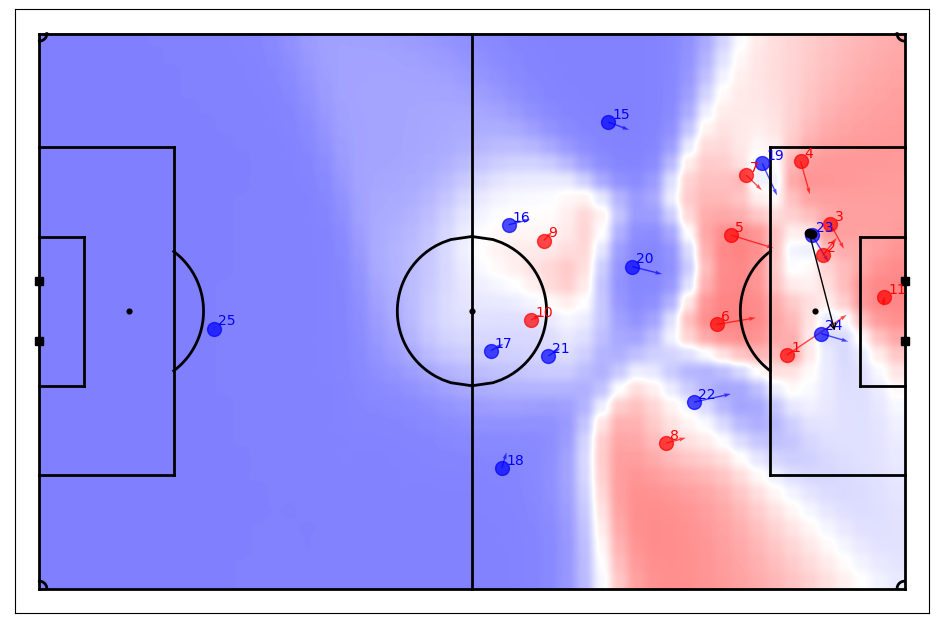

In [20]:
plot_pitch_control_for_event(822, events, tracking_home, tracking_away, params)

## Relevant Pitch
### Transition probability

In [21]:
from scipy.stats import multivariate_normal

In [22]:
def calculate_transition_probability_at_target(target_position, ball_start_pos, PPCF, params):
    '''
    '''
    
    sigma_2 = params['sigma_normal']**2
    normal_distrib = multivariate_normal(mean=ball_start_pos, cov=[[sigma_2,0],[0,sigma_2]])
    T_proba = PPCF**(params['alpha']) * normal_distrib.pdf(target_position)
    
    return(T_proba)

In [23]:
def generate_transition_probability_for_frame(frame, tracking_home, tracking_away, events, params, field_dimen = (106.,68.,), n_grid_cells_x = 50):
    """ generate_transition_probability_for_frame
    
    Evaluates transition probability surface over the entire field at the moment of the given frame
    
    Parameters
    -----------
        frame: instant at which the transition surface should be calculated
        tracking_home: tracking DataFrame for the Home team
        tracking_away: tracking DataFrame for the Away team
        events: Dataframe containing the event data
        params: Dictionary of model parameters (default model parameters can be generated using default_model_params() )
        field_dimen: tuple containing the length and width of the pitch in meters. Default is (106,68)
        n_grid_cells_x: Number of pixels in the grid (in the x-direction) that covers the surface. Default is 50.
                        n_grid_cells_y will be calculated based on n_grid_cells_x and the field dimensions
        
    Returns
    -----------
        T : Transition probability surface
        xgrid: Positions of the pixels in the x-direction (field length)
        ygrid: Positions of the pixels in the y-direction (field width)
    """
    
    # get the details of the event (team in possession, ball_start_position, where team in possession attacks)
    attacking_team = attacking_team_frame(events,frame)
    assert attacking_team=='Home' or attacking_team=='Away', 'attacking team should be Away or Home'
    
    ball_start_pos = np.array( [ tracking_home.loc[frame]['ball_x'], tracking_home.loc[frame]['ball_y'] ] )
    
    where_home_attacks = where_home_team_attacks(tracking_home,events)
    period=tracking_home.loc[frame]['Period']
    if attacking_team=='Home':
        if period==1:
            where_attack=where_home_attacks
        else:
            where_attack=-where_home_attacks
    else:
        if period==1:
            where_attack=-where_home_attacks
        else:
            where_attack=where_home_attacks
        
    # break the pitch down into a grid
    n_grid_cells_y = int(n_grid_cells_x*field_dimen[1]/field_dimen[0])
    xgrid = np.linspace( -field_dimen[0]/2., field_dimen[0]/2., n_grid_cells_x)
    ygrid = np.linspace( -field_dimen[1]/2., field_dimen[1]/2., n_grid_cells_y )
    
    # initialise pitch control grids for attacking and defending teams 
    PPCFa = np.zeros( shape = (len(ygrid), len(xgrid)) )
    PPCFd = np.zeros( shape = (len(ygrid), len(xgrid)) )
    T = np.zeros( shape = (len(ygrid), len(xgrid)) )
    
    # initialise player positions and velocities for pitch control calc (so that we're not repeating this at each grid cell position)
    if attacking_team=='Home':
        attacking_players = initialise_players(tracking_home.loc[frame],'Home',params)
        defending_players = initialise_players(tracking_away.loc[frame],'Away',params)
    else:
        defending_players = initialise_players(tracking_home.loc[frame],'Home',params)
        attacking_players = initialise_players(tracking_away.loc[frame],'Away',params)

    # calculate pitch pitch control model at each location on the pitch
    for i in range( len(ygrid) ):
        for j in range( len(xgrid) ):
            target_position = np.array( [xgrid[j], ygrid[i]] )
            PPCFa[i,j],PPCFd[i,j] = calculate_pitch_control_at_target(target_position, attacking_players, defending_players, ball_start_pos, where_attack, params)
            T[i,j] = calculate_transition_probability_at_target(target_position, ball_start_pos, PPCFa[i,j], params)
    # check probabilitiy sums within convergence
    checksum = np.sum( PPCFa + PPCFd ) / float(n_grid_cells_y*n_grid_cells_x ) 
    assert abs(1-checksum) < params['model_converge_tol'], "Checksum failed: %1.3f" % (1-checksum)
    
    #normalize T to unity
    T=T/np.max(T)
    
    return PPCFa,xgrid,ygrid,T

In [24]:
def plot_transition_proba_for_frame(frame, tracking_home, tracking_away, events, params, alpha = 0.7, include_player_velocities=True, annotate=True, field_dimen = (106.,68.,), n_grid_cells_x = 50):
    """ plot_transition_prob_for_frame(frame, tracking_home, tracking_away, events, params ,PPCF, xgrid, ygrid )
    
    Plots the transition probability surface at the instant of the frame. Player and ball positions are overlaid.
    
    Parameters
    -----------
        frame: the instant at which the pitch control surface should be calculated
        events: Dataframe containing the event data
        tracking_home: (entire) tracking DataFrame for the Home team
        tracking_away: (entire) tracking DataFrame for the Away team
        xgrid: Positions of the pixels in the x-direction (field length) as returned by the generate_pitch_control_for_event in Metrica_PitchControl
        ygrid: Positions of the pixels in the y-direction (field width) as returned by the generate_pitch_control_for_event in Metrica_PitchControl
        alpha: alpha (transparency) of player markers. Default is 0.7
        include_player_velocities: Boolean variable that determines whether player velocities are also plotted (as quivers). Default is False
        annotate: Boolean variable that determines with player jersey numbers are added to the plot (default is False)
        field_dimen: tuple containing the length and width of the pitch in meters. Default is (106,68)
        
    Returns
    -----------
       fig,ax : figure and aixs objects (so that other data can be plotted onto the pitch)
    """    
    # plot frame and event
    fig,ax = mviz.plot_pitch(field_color='white', field_dimen = field_dimen)
    mviz.plot_frame( tracking_home.loc[frame], tracking_away.loc[frame], figax=(fig,ax), PlayerAlpha=alpha, include_player_velocities=include_player_velocities, annotate=annotate )
    
    #generate pitch control
    PPCF, xgrid, ygrid, T =  generate_transition_probability_for_frame(frame, tracking_home, tracking_away, events, params, field_dimen = field_dimen, n_grid_cells_x = n_grid_cells_x)
    
    #find attacking team
    attacking_team = attacking_team_frame(events,frame)

    # plot pitch control surface
    if attacking_team=='Home':
        cmap = 'Reds'
    else:
        cmap = 'Blues'

    ax.imshow(np.flipud(T), extent=(np.amin(xgrid), np.amax(xgrid), np.amin(ygrid), np.amax(ygrid)),interpolation='hanning',vmin=0.0,vmax=1.0,cmap=cmap)
    
    return fig,ax

(<Figure size 1200x800 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1454eba90>)

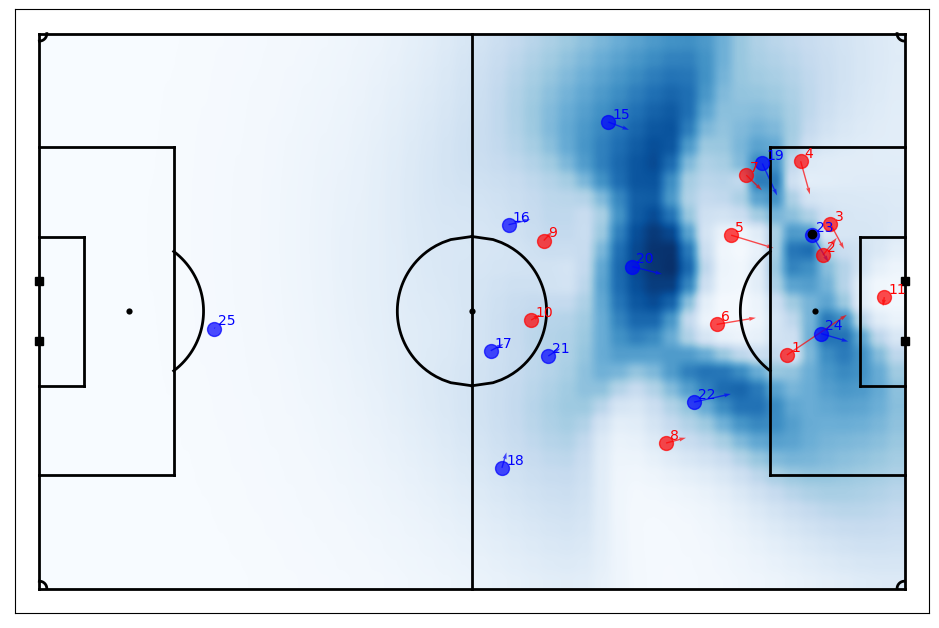

In [312]:
plot_transition_proba_for_frame(53027, tracking_home, tracking_away, events, params)

### Combining pitch control and transition model : Relevant Pitch Control

In [25]:
def generate_relevant_pitch_for_frame(frame, tracking_home, tracking_away, events, params, field_dimen = (106.,68.,), n_grid_cells_x = 50):
    """ generate_relevant_pitch_for_frame
    
    Evaluates relevant pitch for frame surface over the entire field at the moment of the given frame
    
    Parameters
    -----------
        frame: instant at which the transition surface should be calculated
        tracking_home: tracking DataFrame for the Home team
        tracking_away: tracking DataFrame for the Away team
        events: Dataframe containing the event data
        params: Dictionary of model parameters (default model parameters can be generated using default_model_params() )
        field_dimen: tuple containing the length and width of the pitch in meters. Default is (106,68)
        n_grid_cells_x: Number of pixels in the grid (in the x-direction) that covers the surface. Default is 50.
                        n_grid_cells_y will be calculated based on n_grid_cells_x and the field dimensions
        
    Returns
    -----------
        rel_PPCF : relevant pitch surface
        xgrid: Positions of the pixels in the x-direction (field length)
        ygrid: Positions of the pixels in the y-direction (field width)
    """
    
    PPCFa,xgrid,ygrid,T = generate_transition_probability_for_frame(frame, tracking_home, tracking_away, events, params, field_dimen = field_dimen, n_grid_cells_x = n_grid_cells_x)
    rel_PPCF = PPCFa*T
    
    return rel_PPCF,xgrid,ygrid

In [26]:
def plot_relevant_pitch_for_frame(frame, tracking_home, tracking_away, events, params, alpha = 0.7, include_player_velocities=True, annotate=True, field_dimen = (106.,68.,), n_grid_cells_x = 50):
    """ plot_relevant_pitch_for_frame(frame, tracking_home, tracking_away, events, params ,PPCF, xgrid, ygrid )
    
    Plots the relevant pitch surface at the instant of the frame. Player and ball positions are overlaid.
    
    Parameters
    -----------
        frame: the instant at which the pitch control surface should be calculated
        events: Dataframe containing the event data
        tracking_home: (entire) tracking DataFrame for the Home team
        tracking_away: (entire) tracking DataFrame for the Away team
        xgrid: Positions of the pixels in the x-direction (field length) as returned by the generate_pitch_control_for_event in Metrica_PitchControl
        ygrid: Positions of the pixels in the y-direction (field width) as returned by the generate_pitch_control_for_event in Metrica_PitchControl
        alpha: alpha (transparency) of player markers. Default is 0.7
        include_player_velocities: Boolean variable that determines whether player velocities are also plotted (as quivers). Default is False
        annotate: Boolean variable that determines with player jersey numbers are added to the plot (default is False)
        field_dimen: tuple containing the length and width of the pitch in meters. Default is (106,68)
        
    Returns
    -----------
       fig,ax : figure and aixs objects (so that other data can be plotted onto the pitch)
    """    
    # plot frame and event
    fig,ax = mviz.plot_pitch(field_color='white', field_dimen = field_dimen)
    mviz.plot_frame( tracking_home.loc[frame], tracking_away.loc[frame], figax=(fig,ax), PlayerAlpha=alpha, include_player_velocities=include_player_velocities, annotate=annotate )
    
    #generate pitch control
    rel_PPCF, xgrid, ygrid =  generate_relevant_pitch_for_frame(frame, tracking_home, tracking_away, events, params, field_dimen = field_dimen, n_grid_cells_x = n_grid_cells_x)
    
    #find attacking team
    attacking_team = attacking_team_frame(events,frame)
    
    # plot relevant pitch control surface
    if attacking_team=='Home':
        cmap = 'Reds'
    else:
        cmap = 'Blues'
    ax.imshow(np.flipud(rel_PPCF), extent=(np.amin(xgrid), np.amax(xgrid), np.amin(ygrid), np.amax(ygrid)),interpolation='hanning',vmin=0.0,vmax=1.0,cmap=cmap,alpha=1)
    
    return fig,ax

(<Figure size 1200x800 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x14675bdc0>)

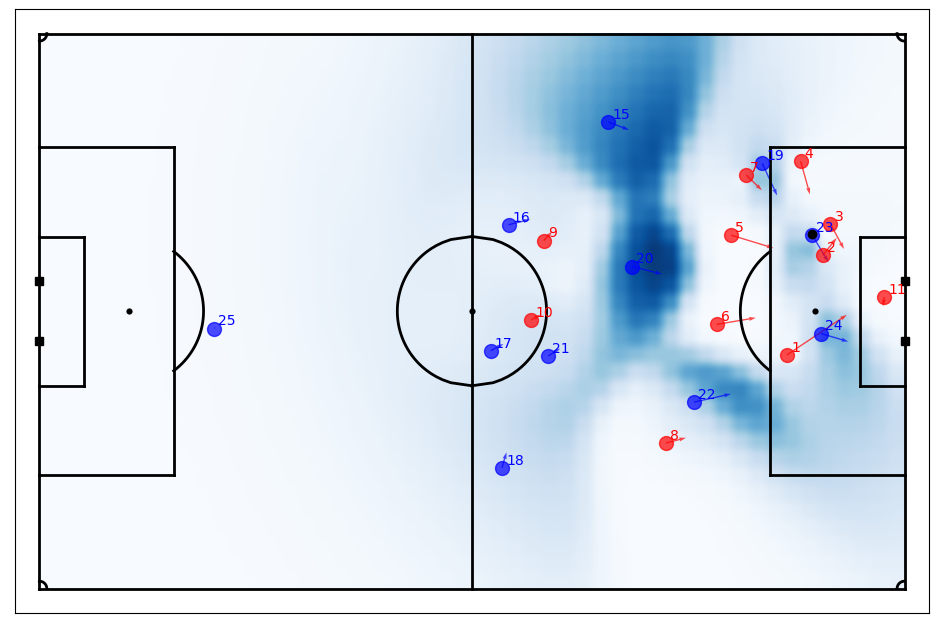

In [313]:
plot_relevant_pitch_for_frame(53027, tracking_home, tracking_away, events, params)

## Scoring probability

In his paper, Spearman uses model based on distance to goal. As there isn't the explicit function used, I decided to use an expected goal model to determine the likelihood of scoring from a location assuming that the ball is successfully controlled by the in possession at this location. The calcul of the expected goal models is detailed in [this notebook](/Users/gabin/Ordinateur/Documents/Informatique/experiments/metrica_football_expected_goals.ipynb). It is mainly based on David Stumper's code in his tutorial made for the youtube channel [Friends of Tracking](https://www.youtube.com/channel/UCUBFJYcag8j2rm_9HkrrA7w).

In [27]:
def calculate_expected_goals_at_target(target_position, where_attack, field_dimen=(106.,68.)):
    
    if where_attack==1:
        x = field_dimen[0]/2-target_position[0]
    else:
        x = target_position[0] + field_dimen[0]/2
    y = target_position[1]
        
    a = np.arctan(7.32 *x /(x**2 + abs(y)**2 - (7.32/2)**2))
    if a<0:
        a = np.pi + a
    angle = a
    distance = np.sqrt(x**2 + abs(y)**2)
    
    # coefficient determined thanks to expected goals model
    c1 = 0.1155
    c2 = -1.2594 
    intercept = 0.7895
    
    bsum = intercept + c1*distance + c2*angle
    
    xG = 1/(1+np.exp(bsum))
    
    return(xG)

In [28]:
def generate_expected_goals_surface_for_frame(frame, tracking_home, tracking_away, events, where_attack, field_dimen=(106.,68.), n_grid_cells_x = 100):
    
    # break the pitch down into a grid
    n_grid_cells_y = int(n_grid_cells_x*field_dimen[1]/field_dimen[0])
    xgrid = np.linspace( -field_dimen[0]/2., field_dimen[0]/2., n_grid_cells_x)
    ygrid = np.linspace( -field_dimen[1]/2., field_dimen[1]/2., n_grid_cells_y )
    
    # initialise expected goals 
    xG = np.zeros( shape = (len(ygrid), len(xgrid)) )

    # calculate pitch pitch control model at each location on the pitch
    for i in range( len(ygrid) ):
        for j in range( len(xgrid) ):

            target_position = np.array( [xgrid[j], ygrid[i]] )
            xG[i,j] = calculate_expected_goals_at_target(target_position, where_attack, field_dimen = field_dimen)
            
    return(xG, xgrid, ygrid)

In [29]:
def plot_expected_goals_surface_for_frame(frame, tracking_home, tracking_away, events, field_dimen=(106.,68.), n_grid_cells_x = 100):
    
    attacking_team = attacking_team_frame(events,frame)
    assert attacking_team=='Home' or attacking_team=='Away', 'attacking team should be Away or Home'
    
    # find where attacking team attacks
    where_home_attacks = where_home_team_attacks(tracking_home,events)
    period=tracking_home.loc[frame]['Period']
    if attacking_team=='Home':
        if period==1:
            where_attack=where_home_attacks
        else:
            where_attack=-where_home_attacks
    else:
        if period==1:
            where_attack=-where_home_attacks
        else:
            where_attack=where_home_attacks
            
            
    xG, xgrid, ygrid =  generate_expected_goals_surface_for_frame(frame, tracking_home, tracking_away, events, where_attack, field_dimen=field_dimen, n_grid_cells_x = n_grid_cells_x)
    fig,ax = mviz.plot_pitch(field_color='white', field_dimen = field_dimen)
    
    xmin = np.amin(xgrid)
    xmax = np.amax(xgrid)
    
    if attacking_team=='Home':
        cmap = plt.cm.Reds
    else:
        cmap = plt.cm.Blues

    ax.imshow(np.flipud(xG), extent=(xmin, xmax, np.amin(ygrid), np.amax(ygrid)),interpolation='hanning',vmin=0.0,vmax=1.0,cmap=cmap,alpha=1)
    
    return(fig,ax)

(<Figure size 1200x800 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x144634e50>)

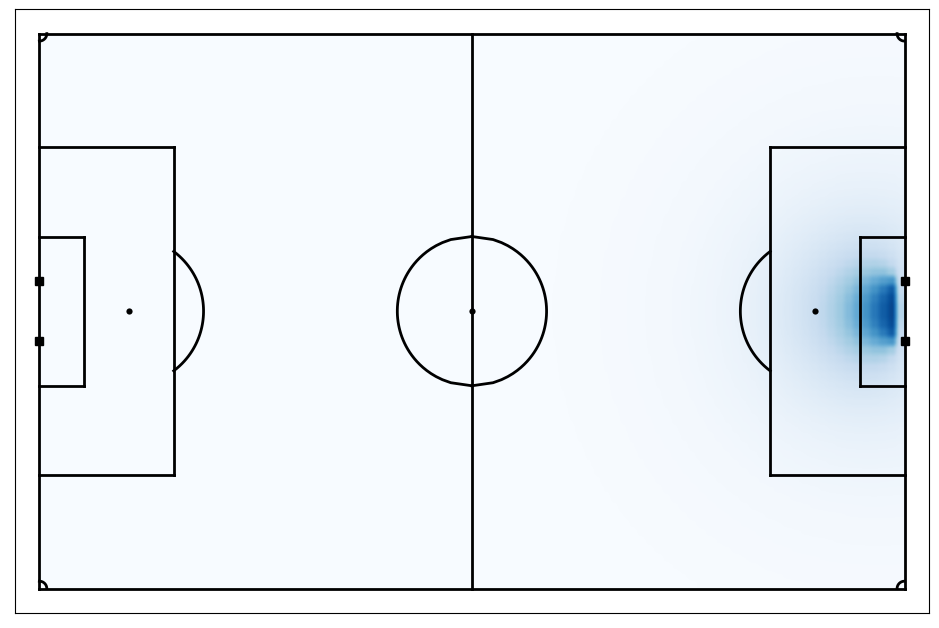

In [300]:
plot_expected_goals_surface_for_frame(53027, tracking_home, tracking_away, events)

## Off Ball Scoring Opportunity = Pitch Control x Transition Model x Scoring probability

In [40]:
def generate_off_ball_scoring_opportunity_for_frame(frame, tracking_home, tracking_away, events, params, field_dimen = (106.,68.,), n_grid_cells_x = 50):
    
    #find attacking team
    attacking_team = attacking_team_frame(events,frame)
    
    # find where attacking team attacks
    where_home_attacks = where_home_team_attacks(tracking_home,events)
    period=tracking_home.loc[frame]['Period']
    if attacking_team=='Home':
        if period==1:
            where_attack=where_home_attacks
        else:
            where_attack=-where_home_attacks
    else:
        if period==1:
            where_attack=-where_home_attacks
        else:
            where_attack=where_home_attacks
    
    xG, xgrid, ygrid = generate_expected_goals_surface_for_frame(frame, tracking_home, tracking_away, events, where_attack, field_dimen=field_dimen, n_grid_cells_x = n_grid_cells_x)
    rel_PPCF,xgrid,ygrid = generate_relevant_pitch_for_frame(frame, tracking_home, tracking_away, events, params, field_dimen = field_dimen, n_grid_cells_x = n_grid_cells_x)
    
    return(xG*rel_PPCF,xgrid,ygrid)

In [48]:
def plot_scoring_opp_for_frame(frame, tracking_home, tracking_away, events, params, alpha = 0.7, include_player_velocities=True, annotate=True, field_dimen = (106.,68.,), n_grid_cells_x = 50):
    
    #find attacking team
    attacking_team = attacking_team_frame(events,frame)
    
    # plot frame and event
    fig,ax = mviz.plot_pitch(field_color='white', field_dimen = field_dimen)
    mviz.plot_frame( tracking_home.loc[frame], tracking_away.loc[frame], figax=(fig,ax), PlayerAlpha=alpha, include_player_velocities=include_player_velocities, annotate=annotate )
    
    #generate pitch control
    off_scoring, xgrid, ygrid = generate_off_ball_scoring_opportunity_for_frame(frame, tracking_home, tracking_away, events, params, field_dimen = field_dimen, n_grid_cells_x = n_grid_cells_x)
    

    # plot pitch control surface
    if attacking_team=='Home':
        cmap = 'Reds'
    else:
        cmap = 'Blues'

    ax.imshow(np.flipud(off_scoring), extent=(np.amin(xgrid), np.amax(xgrid), np.amin(ygrid), np.amax(ygrid)),interpolation='hanning',vmin=0.0,vmax=np.max(off_scoring),cmap=cmap)
    
    print('score probability: ',np.sum(off_scoring))
    
    return(fig,ax)
    

score probability:  4.224400105833114
50 32


(<Figure size 1200x800 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12529d4f0>)

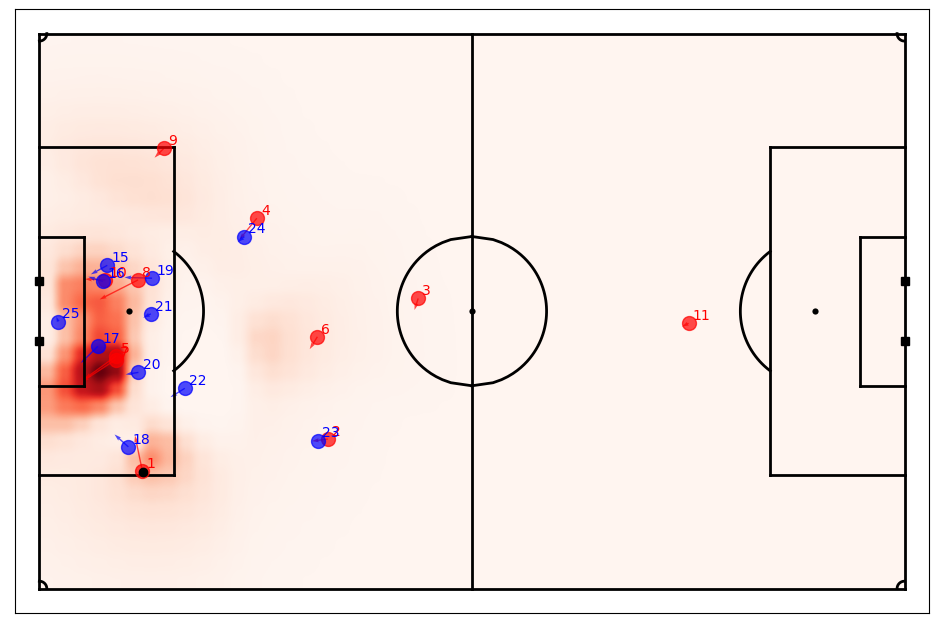

In [49]:
plot_scoring_opp_for_frame(12180, tracking_home, tracking_away, events, params)